# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Since the 3 bin classification did not yield promising results, the same steps will be repeated using the 2 bin classification.

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

None. Assesses whether the 2 bin classification is viable.


---

# Import required libraries

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

print('All Libraries Loaded')

All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [3]:
df_maths = pd.read_csv('outputs/dataset/Expanded_data_with_more_features_clean.csv').filter(['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'MathScore'])
df_maths

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,group C,bachelor's degree,standard,none,71
1,female,group C,some college,standard,none,69
2,female,group B,master's degree,standard,none,87
3,male,group A,associate's degree,free/reduced,none,45
4,male,group C,some college,standard,none,76
...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,59
30637,male,group E,high school,standard,none,58
30638,female,group C,high school,free/reduced,completed,61
30639,female,group D,associate's degree,standard,completed,82


### Setup test pipeline for evaluation

In [4]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=[
                'Gender',
                'EthnicGroup',
                'ParentEduc',
                'LunchType',
                'TestPrep',
                ])),

        ("feature_selection", SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

### Setup model algorithms and blank default hyperparameters

In [5]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

parameters_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

### Custom Confusion Matrix Function from CI Customer Churn Course

In [6]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

### Custom Hyperparameter search class (same as previous notebook)

To select the best algorithm and hyperparameters we will fit a model with each different type / parameter set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

In [7]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Create classification bins (2 bins)

* The classes represent the following ranges: 
{'MathScore': [-inf, 67.0, inf]} 



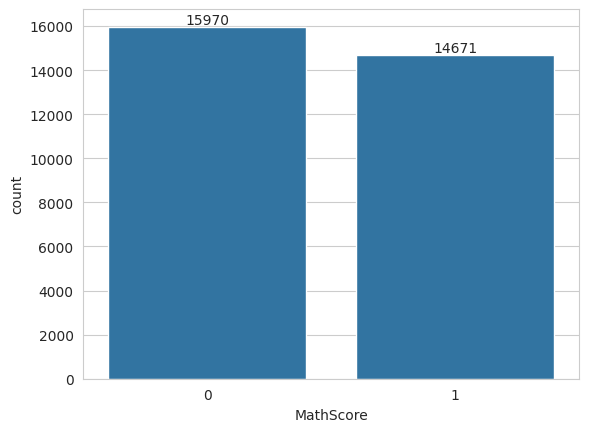

In [8]:
efd = EqualFrequencyDiscretiser(q=2, variables=['MathScore'])
df_maths_efd = efd.fit_transform(df_maths)

print(f"* The classes represent the following ranges: \n{efd.binner_dict_} \n")
fig_maths_efd = sns.countplot(data=df_maths_efd, x='MathScore')
plt.bar_label(fig_maths_efd.containers[0])
plt.show()

In [9]:
df_maths_efd

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,group C,bachelor's degree,standard,none,1
1,female,group C,some college,standard,none,1
2,female,group B,master's degree,standard,none,1
3,male,group A,associate's degree,free/reduced,none,0
4,male,group C,some college,standard,none,1
...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,0
30637,male,group E,high school,standard,none,0
30638,female,group C,high school,free/reduced,completed,0
30639,female,group D,associate's degree,standard,completed,1


### Start model tests
split data into train and test sets

In [10]:
math_train_features, math_test_features, math_train_scores, math_test_scores = train_test_split(
    df_maths_efd.drop(['MathScore'], axis=1),
    df_maths_efd['MathScore'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_features.shape, math_train_scores.shape, "\n* Test set:",  math_test_features.shape, math_test_scores.shape)

* Train set: (24512, 5) (24512,) 
* Test set: (6129, 5) (6129,)


### Search for best algorithm using default hyperparameters

In [11]:
model_search = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [12]:
classifier_summary, grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
classifier_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
5,AdaBoostClassifier,0.686151,0.706787,0.71989,0.011123
1,DecisionTreeClassifier,0.473911,0.486544,0.498235,0.008492
3,GradientBoostingClassifier,0.473911,0.486544,0.498235,0.008492
4,ExtraTreesClassifier,0.473911,0.486544,0.498235,0.008492
0,XGBClassifier,0.477442,0.485995,0.494311,0.006367
2,RandomForestClassifier,0.443311,0.478776,0.498235,0.019538


### Analysis
Reducing the bins to 2 has achieved an acceptable result above a mean score of 0.6 (0.70). The AdaBoostClassifier was clearly the best. The next best algorithm (DecisionTree) was significantly lower ... I do not expect updated hyperparameters to achieve a value better than 0.70, but I will run the test nonetheless.

### Define Hyperparameter list for 2 best models and apply to evaluate the best options

In [13]:
classifier_list = {
    # "XGBClassifier": XGBClassifier(random_state=0),
    # "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
}
 
parameter_list = {
    # "XGBClassifier":{'model__n_estimators': [30,80,200],
    #                   'model__max_depth': [None, 3, 15],
    #                   'model__learning_rate': [0.01,0.1,0.001],
    #                   'model__gamma': [0, 0.1],
    #                         },

    # "GradientBoostingClassifier":{'model__n_estimators': [100,50,140],
    #                               'model__learning_rate':[0.1, 0.01, 0.001],
    #                               'model__max_depth': [3,15, None],
    #                               'model__min_samples_split': [2,50],
    #                               'model__min_samples_leaf': [1,50],
    #                               'model__max_leaf_nodes': [None,50],
    #                         },

    "DecisionTreeClassifier":{'model__max_depth': [None,4, 15],
                              'model__min_samples_split': [2,50],
                              'model__min_samples_leaf': [1,50],
                              'model__max_leaf_nodes': [None,50],
                            },

    "AdaBoostClassifier":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                            }
  }

In [14]:
parameters_search = HyperparameterOptimizationSearch(models=classifier_list, parameters=parameter_list)
parameters_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [15]:
parameters_summary, parameters_pipeliness = parameters_search.score_summary(sort_by='mean_score')
parameters_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__n_estimators,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split
6,AdaBoostClassifier,0.74186,0.772617,0.866614,0.047405,0.1,80,NaN,NaN,NaN,NaN
7,AdaBoostClassifier,0.726559,0.769557,0.866614,0.049728,0.1,150,NaN,NaN,NaN,NaN
5,AdaBoostClassifier,0.568066,0.757866,0.830129,0.097084,0.1,25,NaN,NaN,NaN,NaN
3,AdaBoostClassifier,0.692821,0.723029,0.778344,0.02915,1,150,NaN,NaN,NaN,NaN
2,AdaBoostClassifier,0.692821,0.71479,0.734013,0.01366,1,80,NaN,NaN,NaN,NaN


### Analysis
Tweaking the hyperparameters has achieved a slight imrovement of the score to 0.772. This is still acceptable. As expected, the DecisionTreeClassifier did not improve significantly.

In [16]:
best_model = parameters_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

In [17]:
best_parameters = parameters_pipeliness[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 80}

In [18]:
test_pipeline = parameters_pipeliness[best_model].best_estimator_
test_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'EthnicGroup',
                                           'ParentEduc', 'LunchType',
                                           'TestPrep'])),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=80,
                                    random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['EthnicGroup', 'ParentEduc']


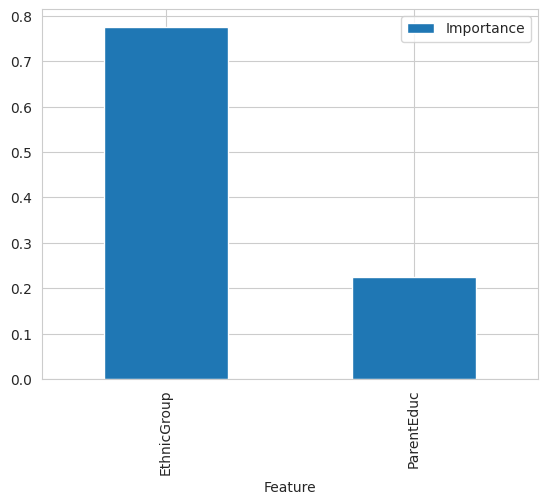

In [19]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(test_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_features)
                                        .columns)

best_features_2 = columns_after_data_cleaning_feat_eng[test_pipeline['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_2 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[test_pipeline['feature_selection'].get_support()],
          'Importance': test_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_efd_2_best_features = df_feature_importance_2['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_2)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_2}")

df_feature_importance_2.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Analysis
This is a surprise and  not expected. The LunchType Variable was not added to the training of the model and ethnicGroup and ParentEducational level are used to predict the  Math Score. I will check the accuracy of using these features of teh model on the test set next.

In [20]:
efd.binner_dict_['MathScore']

[-inf, 67.0, inf]

In [23]:
label_map = ['Might need assistance', 'No assistance needed']
label_map

['Might need assistance', 'No assistance needed']

In [24]:
clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, test_pipeline, label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                                 Actual Might need assistance  \
Prediction Might need assistance                         9555   
Prediction No assistance needed                          3190   

                                 Actual No assistance needed  
Prediction Might need assistance                        6727  
Prediction No assistance needed                         5040  


---  Classification Report  ---
                       precision    recall  f1-score   support

Might need assistance       0.59      0.75      0.66     12745
 No assistance needed       0.61      0.43      0.50     11767

             accuracy                           0.60     24512
            macro avg       0.60      0.59      0.58     24512
         weighted avg       0.60      0.60      0.58     24512
 

#### Test Set ####

---  Confusion Matrix  ---
                                 Actual Might need assistance  \
Prediction Might need assistance     

## Conclusion
### Confusion Matrix
| Test |  Result | 
|---|---|
|True Positives (TP)|2418 correctly predicted "Might need assistance."|
|False Positives (FP)|1642 incorrectly predicted "Might need assistance" with actual "No assistance needed."|
|True Negatives (TN)|1262 correctly predicted "No assistance needed."|
|False Negatives (FN)|807 incorrectly predicted "No assistance needed" with actual"Might need assistance."|

**Might Need Assistance:**
* Precision 0.6 indicates that model identifies someone might need help 60% of the time.
* Recall 0.75 indicates model successfully identifies 75% of all students who might need help
* F1 - balance of Precision and recall of 0.66 indicates reasonable performance above the 0.6 target

**No Assistance Needed:**
* Precision 0.61 indicates that model identifies no help needed 61% of the time.
* Recall 0.43 indicates model 43% of students who actually do not need help are correctly identified
* F1 - balance of Precision and recall of 0.51 indicates model is less accurate at identifying students who do not need help

the Macro Averages are very similar indicating balanced performance accross both classes, but not at a particularly high level. 

Since the model is more likely to predict a false positive, the worst case scenario is that a better student might be 'wrongly' identified as in need of additional help. This is an acceptable outcome as the oppososite would the most problematic ... ie falsley identifying students in need as not needing help.

This would need to be discussed with the customer to see if the outcome is acceptable. The dataset might allow some more tweaking, and sourcing a dataset with no missing values (eliminating the need to impute data) might further improve the model.